# Jacobian Feature Probe

Sanity-check notebook for the copy task: samples a batch, runs `ElmanRNN.analyze_batch`, and prints feature summaries plus a quick histogram.

In [4]:
from re import L
import jax
import jax.numpy as jnp
import numpy as np

from src.models.base import ModelConfig
from src.models.rnn import ElmanRNN, LSTM
from src.models.lru import LinearRecurrentUnit
from src.data.copy_dataset import CopyDataset

num_classes = 10
model_cfg = ModelConfig(input_dim=num_classes, output_dim=num_classes, hidden_dim=32)
# model = ElmanRNN(model_cfg, nonlinearity="relu")
# model = LSTM(model_cfg)
model = LinearRecurrentUnit(model_cfg)
params = model.initialize(jax.random.PRNGKey(0))

dataset = CopyDataset(min_lag=100, max_lag=100, batch_size=2, num_classes=num_classes, seq_length=8)
inputs, targets, mask = dataset()
inputs_oh = jax.nn.one_hot(inputs, num_classes, dtype=jnp.float32)
print("inputs one-hot:", inputs_oh.shape)
print("mask:", mask.shape)


inputs one-hot: (2, 116, 10)
mask: (2, 116)


In [5]:
outputs, tensors, summary = model.analyze_batch(
    params,
    inputs_oh,
    mask,
)

print("frobenius norms shape:", summary.frobenius_norms.shape)
print("active fraction shape:", summary.nonlinearity_active_fraction.shape)
print("scaling shape:", summary.nonlinearity_scaling.shape)

print("mean frobenius:", float(summary.frobenius_norms.mean()))
print("mean active fraction:", float(summary.nonlinearity_active_fraction.mean()))
print("mean scaling:", float(summary.nonlinearity_scaling.mean()))




frobenius norms shape: (2, 116)
active fraction shape: (2, 116)
scaling shape: (2, 116, 32)
mean frobenius: 0.9241382479667664
mean active fraction: 0.0
mean scaling: 1.0


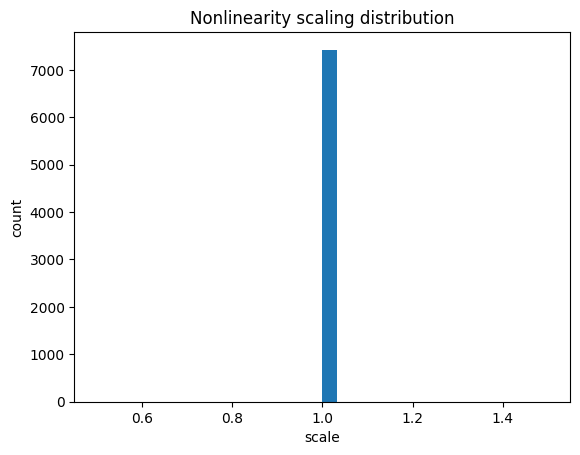

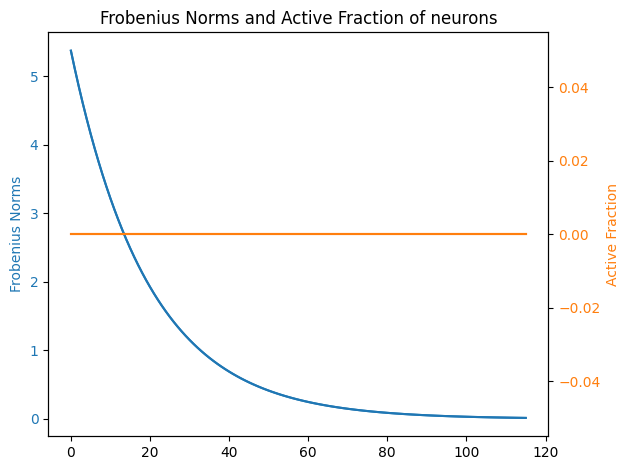

In [6]:
import matplotlib.pyplot as plt

flatten = np.ravel(np.array(summary.nonlinearity_scaling))
plt.hist(flatten, bins=30)
plt.title("Nonlinearity scaling distribution")
plt.xlabel("scale")
plt.ylabel("count")
plt.show()

fig, ax1 = plt.subplots()

ax1.plot(summary.frobenius_norms.T,color='tab:blue')
ax1.set_ylabel('Frobenius Norms', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(summary.nonlinearity_active_fraction.T, color='tab:orange')
ax2.set_ylabel('Active Fraction', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Frobenius Norms and Active Fraction of neurons')
fig.tight_layout()